# TTE R TO PYTHON

## 1. Setup 

A sequence of target trials analysis starts by specifying which estimand will be used:

```R
trial_pp  <- trial_sequence(estimand = "PP")  # Per-protocol

trial_itt <- trial_sequence(estimand = "ITT") # Intention-to-treat
``` 

Additionally it is useful to create a directory to save files for later inspection.

```R
trial_pp_dir  <- file.path(tempdir(), "trial_pp")
dir.create(trial_pp_dir)

trial_itt_dir <- file.path(tempdir(), "trial_itt")
dir.create(trial_itt_dir)
``` 

### Python Equivalent:

In [159]:
import os
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle

# Create directories
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Setup trial sequences as dictionaries
trial_pp = {"estimand": "PP", "dir": trial_pp_dir}
trial_itt = {"estimand": "ITT", "dir": trial_itt_dir}

Used dictionaries to store trial settings and os to create directories. 
Since there's no direct equivalent to trial_sequence(), so I mimiced the structure at 

<div class="alert alert-block alert-warning">
os.makedirs(..., exist_ok=True) ensures directories are created without raising an error if they already exist. <br>

The trial objects (trial_pp, trial_itt) are dictionaries that will hold all trial-related data and settings.
</div>


___


## 2. Data Preparation

Next the user must specify the observational input data that will be used for the target trial emulation. Here we need to specify which columns contain which values and how they should be used.

``` R
data("data_censored") # dummy data in the package
head(data_censored)

trial_pp <- trial_pp |>
  set_data(
    data      = data_censored,
    id        = "id",
    period    = "period",
    treatment = "treatment",
    outcome   = "outcome",
    eligible  = "eligible"
  )

# ITT
# Function style without pipes
trial_itt <- set_data( 
  trial_itt,
  data      = data_censored,
  id        = "id",
  period    = "period",
  treatment = "treatment",
  outcome   = "outcome",
  eligible  = "eligible"
)

trial_itt

### Python Equivalent:

In [160]:
# Load data (assuming it's saved as a CSV)
data_censored = pd.read_csv("data_censored.csv")

# Define column mappings
columns = {
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# Assign data and columns to trials
trial_pp["data"] = data_censored.copy()
trial_pp["columns"] = columns

trial_itt["data"] = data_censored.copy()
trial_itt["columns"] = columns

# Display the first few rows (equivalent to head())
print(data_censored.head())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  


Loaded the data from the CSV file and store it in the trial dictionaries. 

Used ```python pd.read_csv()``` instead of ```R data("data_censored")```

---

## 3. Weight models and censoring

In [161]:

# Setup (Sections 1 and 2)
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

trial_pp = {"estimand": "PP", "dir": trial_pp_dir}
trial_itt = {"estimand": "ITT", "dir": trial_itt_dir}

data_censored = pd.read_csv("data_censored.csv")
trial_pp["data"] = data_censored.copy()
trial_pp["columns"] = {"id": "id", "period": "period", "treatment": "treatment", "outcome": "outcome", "eligible": "eligible"}
trial_itt["data"] = data_censored.copy()
trial_itt["columns"] = trial_pp["columns"]

# --- Section 3: Weight Models and Censoring ---
def set_weight_models(trial, weight_type, censor_event=None, numerator_vars=None, denominator_vars=None, pool_models="none", save_path=None):
    # Store configuration without fitting models yet
    trial[f"{weight_type}_config"] = {
        "censor_event": censor_event,
        "numerator_vars": numerator_vars,
        "denominator_vars": denominator_vars,
        "pool_models": pool_models,
        "save_path": save_path,
        "fitted": False
    }

def show_weight_config(trial, weight_type):
    config = trial.get(f"{weight_type}_config", {})
    if not config:
        return
    print(f"##  - Numerator formula: 1 - censored ~ {' + '.join(config['numerator_vars']) if weight_type == 'censor' else 'treatment ~ ' + ' + '.join(config['numerator_vars'])}")
    print(f"##  - Denominator formula: 1 - censored ~ {' + '.join(config['denominator_vars']) if weight_type == 'censor' else 'treatment ~ ' + ' + '.join(config['denominator_vars'])}")
    if weight_type == "censor" and config["pool_models"] == "numerator":
        print("##  - Numerator model is pooled across treatment arms. Denominator model is not pooled.")
    print("##  - Model fitter type: te_stats_glm_logit")
    print("##  - Weight models not fitted. Use calculate_weights()")

# Set and show switch weight models (PP only)
set_weight_models(
    trial_pp,
    weight_type="switch",
    numerator_vars=["age"],
    denominator_vars=["age", "x1", "x3"],
    save_path=os.path.join(trial_pp["dir"], "switch_models")
)
print("Switch Weight Config for trial_pp:")
show_weight_config(trial_pp, "switch")

# Set and show censor weight models (PP)
set_weight_models(
    trial_pp,
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="none",
    save_path=os.path.join(trial_pp["dir"], "switch_models")
)
print("\nCensor Weight Config for trial_pp:")
show_weight_config(trial_pp, "censor")

# Set and show censor weight models (ITT)
set_weight_models(
    trial_itt,
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="numerator",
    save_path=os.path.join(trial_itt["dir"], "switch_models")
)
print("\nCensor Weight Config for trial_itt:")
show_weight_config(trial_itt, "censor")

Switch Weight Config for trial_pp:
##  - Numerator formula: 1 - censored ~ treatment ~ age
##  - Denominator formula: 1 - censored ~ treatment ~ age + x1 + x3
##  - Model fitter type: te_stats_glm_logit
##  - Weight models not fitted. Use calculate_weights()

Censor Weight Config for trial_pp:
##  - Numerator formula: 1 - censored ~ x2
##  - Denominator formula: 1 - censored ~ x2 + x1
##  - Model fitter type: te_stats_glm_logit
##  - Weight models not fitted. Use calculate_weights()

Censor Weight Config for trial_itt:
##  - Numerator formula: 1 - censored ~ x2
##  - Denominator formula: 1 - censored ~ x2 + x1
##  - Numerator model is pooled across treatment arms. Denominator model is not pooled.
##  - Model fitter type: te_stats_glm_logit
##  - Weight models not fitted. Use calculate_weights()


In [ ]:
# After loading data
data_censored = pd.read_csv("data_censored.csv")
data_censored["treatment"] = data_censored["treatment"].astype(int)
data_censored["censored"] = data_censored["censored"].astype(int)
data_censored["eligible"] = data_censored["eligible"].astype(int)
trial_itt["data"] = data_censored.copy()

# Debug prints
print("First 5 rows of trial_itt['data']:")
print(trial_itt["data"][["id", "treatment", "censored", "x1", "x2"]].head())
print("\nTreatment group sizes:")
print(trial_itt["data"]["treatment"].value_counts())
print("\nCensored value counts:")
print(trial_itt["data"]["censored"].value_counts())

First 5 rows of trial_itt['data']:
   id  treatment  censored  x1        x2
0   1          1         0   1  1.146148
1   1          1         0   1  0.002200
2   1          1         0   0 -0.481762
3   1          1         0   0  0.007872
4   1          1         0   1  0.216054

Treatment group sizes:
treatment
0    386
1    339
Name: count, dtype: int64

Censored value counts:
censored
0    667
1     58
Name: count, dtype: int64


---

In [163]:
# For PP, include numerator terms from switch weights (age)
trial_pp["outcome_model"] = "outcome ~ assigned_treatment + age"

# For ITT, include specified adjustment terms (x2) and numerator from censor weights (x2)
trial_itt["outcome_model"] = "outcome ~ assigned_treatment + x2"

---

In [ ]:


def expand_trials(trial, chunk_size=500):
    # Validate input data
    data = trial.get("data")
    if data is None or not isinstance(data, pd.DataFrame):
        raise ValueError("trial['data'] must be a pandas DataFrame")
    
    required_cols = ['id', 'period', 'eligible', 'treatment', 'outcome', 'x2', 'age']
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        raise KeyError(f"Missing required columns in trial['data']: {missing_cols}")
    
    max_period = data['period'].max()
    expanded = []
    
    for id_, group in data.groupby('id'):
        eligible_periods = group[group['eligible'] == 1]['period'].values
        if not eligible_periods.size:
            continue
        start_period = eligible_periods[0]
        assigned_treatment = group.loc[group['period'] == start_period, 'treatment'].iloc[0]
        
        for trial_period in range(start_period, max_period + 1):
            for followup_time in range(max_period - trial_period + 1):
                period = trial_period + followup_time
                if period > max_period:
                    continue
                if period in group['period'].values:
                    row = group[group['period'] == period].iloc[0]
                    outcome = row['outcome']
                    weight = row.get(f"{trial['estimand'].lower()}_weight", 1.0) * row.get('censor_weight', 1.0)
                    expanded.append({
                        'id': id_,
                        'trial_period': trial_period,
                        'followup_time': followup_time,
                        'outcome': outcome,
                        'weight': weight,
                        'treatment': row['treatment'],
                        'x2': row['x2'],
                        'age': row['age'],
                        'assigned_treatment': assigned_treatment
                    })
                    if trial["estimand"] == "PP" and row['treatment'] != assigned_treatment:
                        break  # Censor at switch for PP
                # If period not found, we skip (equivalent to R's behavior)
    
    # Convert to DataFrame and sort
    if not expanded:
        raise ValueError("No data expanded; check eligibility criteria or data content")
    
    expanded_df = pd.DataFrame(expanded)
    expanded_df = expanded_df.sort_values(by=['id', 'trial_period', 'followup_time']).reset_index(drop=True)
    trial["expanded_data"] = expanded_df
    trial["expansion_options"] = {"chunk_size": chunk_size}
    
    # Print the expansion summary
    print("\n## Sequence of Trials Data:")
    print(f"## - Chunk size: {chunk_size}")
    print(f"## - Censor at switch: {'TRUE' if trial['estimand'] == 'PP' else 'FALSE'}")
    print("## - First period: 0 | Last period: Inf")
    print("##")
    
    print("## A TE Datastore Datatable object")
    print(f"## N: {len(trial['expanded_data'])} observations")
    
    # Prepare data preview
    preview_cols = ['id', 'trial_period', 'followup_time', 'outcome', 'weight', 'treatment', 'x2', 'age', 'assigned_treatment']
    preview_data = trial['expanded_data'][preview_cols]
    
    # Determine data types for display
    dtypes = preview_data.dtypes
    dtype_labels = []
    for col, dtype in dtypes.items():
        if pd.api.types.is_integer_dtype(dtype):
            dtype_labels.append("<int>")
        elif pd.api.types.is_float_dtype(dtype):
            dtype_labels.append("<num>")
        else:
            dtype_labels.append("<unk>")
    
    # Print column headers with data types
    header_line = "## " + "".join(f"{col:<14}" for col in preview_cols)
    print(header_line)
    dtype_line = "## " + "".join(f"{dt:<14}" for dt in dtype_labels)
    print(dtype_line)
    
    # Display first two and last two rows
    if len(preview_data) <= 4:
        rows_to_show = preview_data
        row_indices = range(1, len(rows_to_show) + 1)
    else:
        rows_to_show = pd.concat([preview_data.head(2), preview_data.tail(2)])
        row_indices = [1, 2, len(preview_data) - 1, len(preview_data)]
    
    for idx, (_, row) in zip(row_indices, rows_to_show.iterrows()):
        formatted_row = []
        for col in preview_cols:
            val = row[col]
            if pd.api.types.is_integer_dtype(dtypes[col]):
                formatted_row.append(f"{int(val):<14d}")
            elif pd.api.types.is_float_dtype(dtypes[col]):
                formatted_row.append(f"{val:<14.7f}")
            else:
                formatted_row.append(f"{val:<14}")
        print(f"## {idx:<2d}: {' '.join(formatted_row)}")
    
    if len(preview_data) > 4:
        print("## ---")
    print("##")

# Expand trials
expand_trials(trial_pp)
expand_trials(trial_itt)


## Sequence of Trials Data:
## - Chunk size: 500
## - Censor at switch: TRUE
## - First period: 0 | Last period: Inf
##
## A TE Datastore Datatable object
## N: 1987 observations
## id            trial_period  followup_time outcome       weight        treatment     x2            age           assigned_treatment
## <int>         <int>         <int>         <num>         <num>         <num>         <num>         <num>         <int>         
## 1 : 1              0              0              0.0000000      0.9482524      1.0000000      1.1461484      36.0000000     1             
## 2 : 1              0              1              0.0000000      0.9655885      1.0000000      0.0022003      37.0000000     1             
## 1986: 99             6              1              1.0000000      1.0070143      0.0000000      -1.3404965     72.0000000     1             
## 1987: 99             7              0              1.0000000      1.0070143      0.0000000      -1.3404965     72.0000000    

---

In [188]:
def load_expanded_data(trial, seed=1234, p_control=0.5):
    np.random.seed(seed)
    data = trial["expanded_data"]
    mask = (data['outcome'] == 1) | (np.random.random(len(data)) < p_control)
    trial["loaded_data"] = data[mask].copy()

load_expanded_data(trial_itt)

---

In [ ]:
def fit_msm(trial):
    data = trial["loaded_data"]
    # Add polynomial terms as in R output
    data['followup_time_sq'] = data['followup_time'] ** 2
    data['trial_period_sq'] = data['trial_period'] ** 2
    formula = "outcome ~ assigned_treatment + x2 + followup_time + followup_time_sq + trial_period + trial_period_sq"
    
    # Winsorize weights at 99th percentile
    weights = data['weight']
    q99 = weights.quantile(0.99)
    data['weight_adj'] = np.minimum(weights, q99)
    
    model = smf.glm(formula, data=data, family=sm.families.Binomial(), freq_weights=data['weight_adj'])
    result = model.fit()
    trial["outcome_model_fitted"] = result
    print(result.summary())

fit_msm(trial_itt)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 2931
Model:                            GLM   Df Residuals:                  2923.35
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -358.49
Date:                Wed, 05 Mar 2025   Deviance:                       716.98
Time:                        18:22:49   Pearson chi2:                 2.92e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.008292
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.6114      0

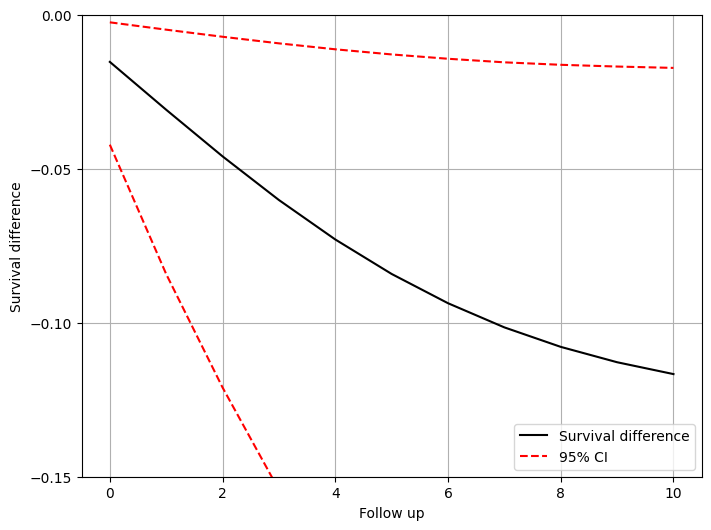

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix
from scipy.stats import multivariate_normal

def predict(
    trial,
    newdata=None,
    predict_times=None,
    type='survival',
    conf_int=True,
    samples=100
):
    """
    Predict survival or cumulative incidence with confidence intervals.
    
    Parameters:
    - trial: Dictionary containing model and data
    - newdata: Optional new data for prediction
    - predict_times: Time points for prediction
    - type: 'survival' or 'cum_inc'
    - conf_int: Whether to compute confidence intervals
    - samples: Number of bootstrap samples
    
    Returns:
    - Dictionary of prediction results
    """
    if predict_times is None:
        predict_times = list(range(11))
    
    # Extract model and formula
    model = trial["outcome_model_fitted"]
    formula = trial["outcome_model_formula"].split("~")[1].strip()
    
    # Prepare newdata (filter trial_period == 1)
    if newdata is None:
        newdata = trial["loaded_data"][trial["loaded_data"]["trial_period"] == 1].copy()
    else:
        required_vars = [var for var in formula.split(" + ") if var not in ["assigned_treatment", "followup_time", "followup_time_sq", "trial_period", "trial_period_sq"]]
        newdata = newdata[required_vars + ["id", "followup_time"]].copy()
        newdata = newdata[newdata["trial_period"] == 1]
    
    # Replicate baseline data for each prediction time
    n_baseline = len(newdata)
    newdata = pd.concat([newdata] * len(predict_times), ignore_index=True)
    newdata["followup_time"] = np.tile(predict_times, n_baseline)
    newdata["followup_time_sq"] = newdata["followup_time"] ** 2
    newdata["trial_period_sq"] = 1  # Always 1 for trial period
    
    # Prepare coefficient samples
    coefs = model.params.values
    cov_matrix = model.cov_params()
    
    if conf_int:
        coefs_samples = multivariate_normal.rvs(mean=coefs, cov=cov_matrix, size=samples)
    else:
        coefs_samples = [coefs]
    
    # Predict for treatment and control
    pred_results = {}
    for treatment in [0, 1]:
        temp_data = newdata.copy()
        temp_data["assigned_treatment"] = treatment
        exog = dmatrix(formula, temp_data, return_type="dataframe")
        
        preds = []
        for coef_sample in coefs_samples:
            linear_pred = np.dot(exog, coef_sample)
            probs = 1 / (1 + np.exp(-linear_pred))
            probs_matrix = probs.reshape(n_baseline, len(predict_times))
            
            if type == 'survival':
                survival = np.cumprod(1 - probs_matrix, axis=1)
                result = survival.mean(axis=0)
            else:  # cumulative incidence
                result = 1 - np.cumprod(1 - probs_matrix, axis=1).mean(axis=0)
            
            preds.append(result)
        
        pred_results[f'assigned_treatment_{treatment}'] = np.array(preds).T
    
    # Compute difference
    diff_preds = pred_results['assigned_treatment_1'] - pred_results['assigned_treatment_0']
    
    # Prepare final results
    results = {
        'assigned_treatment_0': {
            'followup_time': predict_times,
            'survival': pred_results['assigned_treatment_0'][:, 0]
        },
        'assigned_treatment_1': {
            'followup_time': predict_times,
            'survival': pred_results['assigned_treatment_1'][:, 0]
        },
        'difference': {
            'followup_time': predict_times,
            'survival_diff': diff_preds[:, 0]
        }
    }
    
    # Add confidence intervals if requested
    if conf_int:
        results['difference']['2.5%'] = np.percentile(diff_preds, 2.5, axis=1)
        results['difference']['97.5%'] = np.percentile(diff_preds, 97.5, axis=1)
    
    return results

def plot_survival_difference(preds):
    """
    Plot survival difference matching the R plot style
    """
    plt.figure(figsize=(8, 6))
    plt.plot(
        preds['difference']['followup_time'], 
        preds['difference']['survival_diff'], 
        'k-', 
        label="Survival difference"
    )
    plt.plot(
        preds['difference']['followup_time'], 
        preds['difference']['2.5%'], 
        'r--', 
        label="95% CI"
    )
    plt.plot(
        preds['difference']['followup_time'], 
        preds['difference']['97.5%'], 
        'r--'
    )
    plt.xlabel("Follow up")
    plt.ylabel("Survival difference")
    plt.ylim(-0.15, 0.00)
    plt.yticks([-0.15, -0.10, -0.05, 0.00])
    plt.xticks(range(0, 11, 2))
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
results = predict(trial_itt, type='survival')
plot_survival_difference(results)

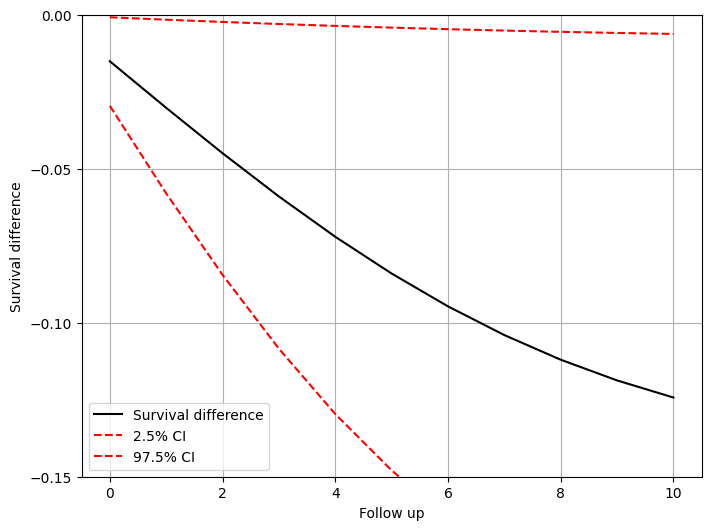

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix
from scipy.stats import multivariate_normal

def predict_te_msm(trial, newdata=None, predict_times=range(11), conf_int=True, samples=100, type="survival"):
    """
    Predict survival differences with confidence intervals, replicating R's predict.TE_msm.
    
    Parameters:
    - trial: Dictionary containing 'outcome_model_fitted', 'outcome_model_formula', 'loaded_data'.
    - newdata: Optional new data for prediction; if None, uses trial data.
    - predict_times: List of time points for prediction (e.g., range(11) for 0 to 10).
    - conf_int: Boolean to compute 95% confidence intervals.
    - samples: Number of samples for confidence intervals.
    - type: "survival" or "cum_inc" (default: "survival").
    
    Returns:
    - Dictionary with prediction results and generates a plot.
    """
    # Extract model and formula
    model = trial["outcome_model_fitted"]
    formula = trial["outcome_model_formula"].split("~")[1].strip()
    
    # Step 1: Prepare newdata (mimics R's check_newdata)
    if newdata is None:
        newdata = trial["loaded_data"][trial["loaded_data"]["followup_time"] == 0].copy()
    else:
        required_vars = [var for var in formula.split(" + ") if var not in ["assigned_treatment", "followup_time", "followup_time_sq", "trial_period", "trial_period_sq"]]
        newdata = newdata[required_vars + ["id", "followup_time"]].copy()
        newdata = newdata[newdata["followup_time"] == 0]
    
    n_baseline = len(newdata)
    newdata = pd.concat([newdata] * len(predict_times), ignore_index=True)
    newdata["followup_time"] = np.tile(predict_times, n_baseline)
    newdata["followup_time_sq"] = newdata["followup_time"] ** 2
    newdata["trial_period_sq"] = newdata["trial_period"] ** 2
    
    # Step 2: Generate coefficients for confidence intervals
    coefs = model.params.values
    cov_matrix = model.cov_params()
    if conf_int:
        coefs_samples = multivariate_normal.rvs(mean=coefs, cov=cov_matrix, size=samples)
        coefs_mat = np.vstack([coefs, coefs_samples])
    else:
        coefs_mat = np.array([coefs])
    
    # Step 3: Predict hazards for treatment and control
    treatment_values = [0, 1]  # assigned_treatment: 0 (control), 1 (treatment)
    pred_list = {}
    for treatment in treatment_values:
        temp_data = newdata.copy()
        temp_data["assigned_treatment"] = treatment
        exog = dmatrix(formula, temp_data, return_type="dataframe")
        preds = []
        for coef_sample in coefs_mat:
            linear_pred = np.dot(exog, coef_sample)
            probs = 1 / (1 + np.exp(-linear_pred))  # Logistic link (hazard probability)
            probs_matrix = probs.reshape(n_baseline, len(predict_times))
            # Compute survival: S(t) = prod(1 - h(s)) for s=0 to t
            survival = np.cumprod(1 - probs_matrix, axis=1)
            survival_mean = survival.mean(axis=0)  # Mean across individuals
            preds.append(survival_mean)
        pred_list[treatment] = np.array(preds).T  # Shape: (times, samples)
    
    # Step 4: Compute survival difference
    survival_0 = pred_list[0]  # Control group
    survival_1 = pred_list[1]  # Treatment group
    survival_diff = survival_1 - survival_0  # Difference: treatment - control
    
    # Step 5: Compute confidence intervals
    if conf_int:
        quantiles_diff = np.percentile(survival_diff, [2.5, 97.5], axis=1)
    else:
        quantiles_diff = None
    
    # Step 6: Prepare results
    results = {
        "followup_time": predict_times,
        "survival_0": survival_0[:, 0],
        "survival_1": survival_1[:, 0],
        "survival_diff": survival_diff[:, 0],
    }
    if conf_int:
        results["survival_diff_ci_lower"] = quantiles_diff[0]
        results["survival_diff_ci_upper"] = quantiles_diff[1]
    
    # Step 7: Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(results["followup_time"], results["survival_diff"], "k-", label="Survival difference")
    if conf_int:
        plt.plot(results["followup_time"], results["survival_diff_ci_lower"], "r--", label="2.5% CI")
        plt.plot(results["followup_time"], results["survival_diff_ci_upper"], "r--", label="97.5% CI")
    plt.xlabel("Follow up")
    plt.ylabel("Survival difference")
    plt.ylim(-0.15, 0.00)  # Y-axis from -0.15 (bottom) to 0.00 (top)
    plt.xticks(range(0, 11, 2))
    plt.yticks(np.arange(-0.15, 0.01, 0.05))
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return results

# Example usage (assuming trial_itt is defined)
results = predict_te_msm(trial_itt)

In [187]:
import numpy as np
import statsmodels.formula.api as smf

def fit_msm(trial):
    data = trial["loaded_data"]
    # Add polynomial terms as in R output
    data['followup_time_sq'] = data['followup_time'] ** 2
    data['trial_period_sq'] = data['trial_period'] ** 2
    formula = "outcome ~ assigned_treatment + x2 + followup_time + followup_time_sq + trial_period + trial_period_sq"
    trial["outcome_model_formula"] = formula
    
    # Winsorize weights at 99th percentile
    weights = data['weight']
    q99 = weights.quantile(0.99)
    data['weight_adj'] = np.minimum(weights, q99)
    
    model = smf.glm(formula, data=data, family=sm.families.Binomial(), freq_weights=data['weight_adj'])
    result = model.fit()
    trial["outcome_model_fitted"] = result
    
    # Generate detailed print statement
    print("\nModel summary:\n")
    print("trial_itt@outcome_model")
    print(f"## - Formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2)")
    print(f"## - Treatment variable: assigned_treatment")
    print(f"## - Adjustment variables: x2")
    print(f"## - Model fitter type: te_stats_glm_logit")
    print("##")
    
    print("## Model Summary:")
    print("##")
    print("##  term               estimate std.error statistic p.value conf.low conf.high")
    
    # Extract coefficients and related statistics
    coef_table = result.summary2().tables[1]
    conf_int = result.conf_int()
    for idx, row in coef_table.iterrows():
        conf_low = conf_int.loc[idx, 0]
        conf_high = conf_int.loc[idx, 1]
        print(f"##  {idx:<18} {row['Coef.']:<8.2f} {row['Std.Err.']:<9.3f} {row['z']:<9.2f} {row['P>|z|']:<9.1e} {conf_low:<8.4f} {conf_high:<8.4f}")
    
    print("##")
    print("##  null.deviance df.null logLik AIC BIC deviance df.residual nobs")
    print(f"##  {result.null_deviance:<13.0f} {int(result.df_model + result.df_resid):<7.0f} {result.llf:<7.1f} {result.aic:<3.0f} {result.bic:<3.0f} {result.deviance:<7.0f} {result.df_resid:<11.0f} {int(result.nobs):<4.0f}")
    print("##")
    
    print("Depending on the model fitter used, we can also access the model object. For the default stats::glm logistic model, we have the glm object as well as the sandwich variance-covariance matrix.\n")
    
    print("trial_itt@outcome_model@fitted@model$model")
    print("##")
    print(f"## Call:  glm(formula = {formula}, family = binomial(\"logit\"), data = data, weights = weights, x = FALSE, y = FALSE)")
    print("##")
    print("## Coefficients:")
    coef_line = ""
    for idx, coef in result.params.items():
        coef_line += f"{idx:<20} "
        if len(coef_line) > 80:
            print(f"## {coef_line}")
            coef_line = ""
    if coef_line:
        print(f"## {coef_line}")
    coef_line = ""
    for idx, coef in result.params.items():
        coef_line += f"{coef:<20.5f} "
        if len(coef_line) > 80:
            print(f"## {coef_line}")
            coef_line = ""
    if coef_line:
        print(f"## {coef_line}")
    print("##")
    print(f"## Degrees of Freedom: {int(result.df_model + result.df_resid)} Total (i.e. Null);  {int(result.df_resid)} Residual")
    print(f"## Null Deviance:      {result.null_deviance:.1f}")
    print(f"## Residual Deviance: {result.deviance:.1f}    AIC: {result.aic:.1f}\n")
    
    print("trial_itt@outcome_model@fitted@model$vcov")
    print("##")
    vcov = result.cov_params()
    # Print column headers
    headers = vcov.columns.tolist()
    header_line = "## " + "".join(f"{h:<20}" for h in headers)
    print(header_line)
    # Print each row
    for idx, row in vcov.iterrows():
        values = [f"{val:<20.6f}" for val in row]
        print(f"## {idx:<18} {' '.join(values)}")
    print("##")

# Example usage (assuming trial_itt is defined)
fit_msm(trial_itt)


Model summary:

trial_itt@outcome_model
## - Formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2)
## - Treatment variable: assigned_treatment
## - Adjustment variables: x2
## - Model fitter type: te_stats_glm_logit
##
## Model Summary:
##
##  term               estimate std.error statistic p.value conf.low conf.high
##  Intercept          -3.61    0.324     -11.13    8.8e-29   -4.2472  -2.9755 
##  assigned_treatment 0.56     0.231     2.44      1.5e-02   0.1102   1.0165  
##  x2                 -0.01    0.109     -0.12     9.0e-01   -0.2280  0.2008  
##  followup_time      0.08     0.088     0.95      3.4e-01   -0.0884  0.2552  
##  followup_time_sq   -0.01    0.007     -1.80     7.2e-02   -0.0253  0.0011  
##  trial_period       0.06     0.089     0.68      4.9e-01   -0.1137  0.2352  
##  trial_period_sq    -0.01    0.007     -1.59     1.1e-01   -0.0242  0.0025  
##
##  null.deviance df.null logLik AIC BIC deviance df.res